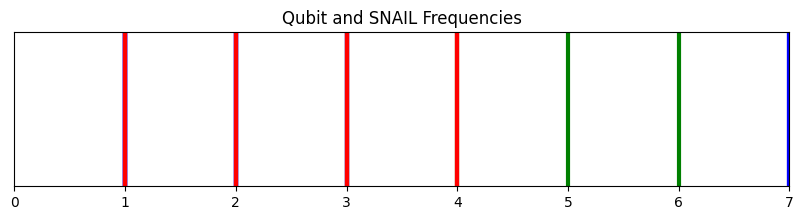

In [1]:
import matplotlib.pyplot as plt
from ipywidgets import interactive_output, VBox, HBox, FloatSlider, Layout
import numpy as np

# Create a figure and axes for plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Number of qubits can be adjusted here
num_qubits = 4

# Create sliders for qubits and SNAIL
sliders = {
    f"qubit_{i}": FloatSlider(
        value=np.random.uniform(3, 6),
        min=0,
        max=6,
        description=f"Qubit {i}",
        # orientation="vertical",
        continuous_update=False,
        step=0.01,
    )
    for i in range(num_qubits)
}
sliders["snail"] = FloatSlider(
    value=4.5,
    min=3,
    max=7,
    description="SNAIL",
    # orientation="vertical",
    continuous_update=False,
    step=0.01,
)


# initialize the dictionary
initial_frequencies = np.linspace(3, 7, num_qubits + 1)  # +1 for SNAIL
frequency_dict = {}
for qubit in range(num_qubits):
    frequency_dict[f"qubit_{qubit}"] = ax.axvline(
        initial_frequencies[qubit], color="green", linestyle="-", linewidth=3
    )
frequency_dict["snail"] = ax.axvline(
    initial_frequencies[-1], color="red", linestyle="-", linewidth=2
)

# add frequency pairs to the dictionary (sum and difference)
# use frozenset() to ensure that the order of the keys doesn't matter
for i, mode1 in enumerate(initial_frequencies):
    for j, mode2 in enumerate(initial_frequencies):
        if i == j:
            continue
        key1 = f"qubit_{i}"
        key2 = f"qubit_{j}"
        if i == len(initial_frequencies) - 1:
            key1 = "snail"
        if j == len(initial_frequencies) - 1:
            key2 = "snail"

        freq1 = initial_frequencies[i]
        freq2 = initial_frequencies[j]

        sum_freq = freq1 + freq2
        diff_freq = abs(freq1 - freq2)
        sum_key = f"sum_{key1}_{key2}"
        diff_key = f"diff_{key1}_{key2}"
        # frequency_dict[sum_key] = sum_freq
        # frequency_dict[diff_key] = diff_freq

        alpha = 1
        if "snail" in sum_key:
            color = "red"
            # transparenet
            # alpha = 0
        else:
            color = "blue"

        frequency_dict[sum_key] = ax.axvline(
            sum_freq, color=color, linestyle="-", linewidth=3, alpha=alpha
        )
        frequency_dict[diff_key] = ax.axvline(
            diff_freq, color=color, linestyle="-", linewidth=3, alpha=alpha
        )

# Initialize plot properties
ax.set_xlim(0, 7)
ax.get_yaxis().set_visible(False)
plt.title("Qubit and SNAIL Frequencies")


# Function to update the plot
def update_plot(**mode_frequencies):
    # Update the frequency lines
    for mode, freq in mode_frequencies.items():
        frequency_dict[mode].set_xdata([freq, freq])

    # update the pairs
    for key1, freq1 in mode_frequencies.items():
        for key2, freq2 in mode_frequencies.items():
            if key1 == key2:
                continue
            sum_freq = freq1 + freq2
            diff_freq = abs(freq1 - freq2)
            sum_key = f"sum_{key1}_{key2}"
            diff_key = f"diff_{key1}_{key2}"
            frequency_dict[sum_key].set_xdata([sum_freq, sum_freq])
            frequency_dict[diff_key].set_xdata([diff_freq, diff_freq])

    # Redraw the figure to update the lines
    fig.canvas.draw_idle()


# Layout adjustments for better UI
slider_layout = VBox(list(sliders.values()), layout=Layout(width="400"))
plot_layout = interactive_output(update_plot, sliders)

# Display the interactive widgets alongside the plot
display(HBox([slider_layout, plot_layout]))